In [23]:
google_colab = False

# Google Colab用事前準備

In [24]:
# install
try:
    import binarybrain as bb
except:
    if google_colab and False:
        !pip install pybind11
        %cd /content
        !nvcc -V
        !sudo rm -fr BinaryBrain
        !rm -fr BinaryBrain
        !git clone --recursive -b ver3_develop https://github.com/ryuz/BinaryBrain.git
        %cd /content/BinaryBrain/python
        !sh copy_src.sh
        !python3 setup.py build
        !python3 setup.py develop

        import binarybrain as bb

In [25]:
# mount
if google_colab:
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My Drive/git-work/BinaryBrain_ver3_develop/tests/python

In [27]:
import binarybrain as bb

import importlib
importlib.reload(bb)

prop = bb.get_device_properties()
print(prop)


name                     : GeForce GTX 1660 SUPER
totalGlobalMem           : 6442450944
sharedMemPerBlock        : 49152
regsPerBlock             : 65536
warpSize                 : 32
memPitch                 : 2147483647
maxThreadsPerBlock       : 1024
maxThreadsDim[0]         : 1024
maxThreadsDim[1]         : 1024
maxThreadsDim[2]         : 64
maxGridSize[0]           : 2147483647
maxGridSize[1]           : 65535
maxGridSize[2]           : 65535
clockRate                : 1800000
totalConstMem            : 65536
major                    : 7
minor                    : 5
textureAlignment         : 512
deviceOverlap            : 1
multiProcessorCount      : 22
kernelExecTimeoutEnabled : 1
integrated               : 0
canMapHostMemory         : 1
computeMode              : 0




# メインコード

In [5]:
import binarybrain as bb
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [6]:
def make_test_image(src_x, src_t):
    dst_x = np.ndarray((len(src_x),  1, 28, 28), dtype=np.float32)
    dst_t = np.ndarray((len(src_x), 11, 28, 28), dtype=np.float32)
    for i in range(len(src_x)):
        x_img = src_x[i].copy()
        t_img = np.zeros((11, 28*28), dtype=np.float32)
        mask0 = x_img <= 0.5
        mask1 = x_img > 0.5
        for j in range(10):
          t_img[j,mask1] = src_t[i][j]
        t_img[10,mask0] = 1.0
        dst_x[i] = x_img.reshape(1, 28, 28)
        dst_t[i] = t_img.reshape(11, 28, 28)
    return dst_x, dst_t

In [7]:
def make_test_data(src_x, src_t):
    x, t = make_test_image(src_x, src_t)

    dst_x = np.ndarray((len(src_x) // 4,  1*56*56), dtype=np.float32)
    dst_t = np.ndarray((len(src_x) // 4, 11*56*56), dtype=np.float32)
    for i in range(len(x) // 4):
        x_img = np.hstack((np.dstack((x[i*4+0], x[i*4+1])), np.dstack((x[i*4+2], x[i*4+3]))))
        t_img = np.hstack((np.dstack((t[i*4+0], t[i*4+1])), np.dstack((t[i*4+2], t[i*4+3]))))
        dst_x[i] = x_img.reshape(-1)
        dst_t[i] = t_img.reshape(-1)
    return dst_x, dst_t

In [8]:
# load MNIST data
td = bb.load_mnist()

td['x_train'], td['t_train'] = make_test_data(td['x_train'], td['t_train'])
td['x_test'],  td['t_test']  = make_test_data(td['x_test'], td['t_test'])
td['x_shape'] = [56, 56, 1]
td['t_shape'] = [56, 56, 11]

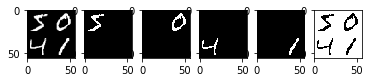

In [9]:
plt.subplot(161)
plt.imshow(td['x_train'][0].reshape(56, 56), 'gray')
plt.subplot(162)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[5], 'gray')
plt.subplot(163)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[0], 'gray')
plt.subplot(164)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[4], 'gray')
plt.subplot(165)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[1], 'gray')
plt.subplot(166)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[10], 'gray')

In [10]:
color_table = [
    [0xe6, 0x00, 0x12],  # 0
    [0x92, 0x07, 0x83],  # 1
    [0x1d, 0x20, 0x88],  # 2
    [0x00, 0x68, 0xb7],  # 3
    [0x00, 0xa0, 0xe9],  # 4
    [0x00, 0x9e, 0x96],  # 5
    [0x00, 0x99, 0x44],  # 6
    [0x8f, 0xc3, 0x1f],  # 7
    [0xff, 0xf1, 0x00],  # 8
    [0xf3, 0x98, 0x00],  # 9
    [0x00, 0x00, 0x00],  # BGC
]

def frame_to_image(frame):
    idx_img = np.argmax(frame, axis=0)
    rgb_img = np.ndarray((idx_img.shape[0], idx_img.shape[1], 3), dtype=np.uint8)
    for y in range(idx_img.shape[1]):
        for x in range(idx_img.shape[0]):
            rgb_img[y][x] = color_table[idx_img[y][x]]
    return rgb_img

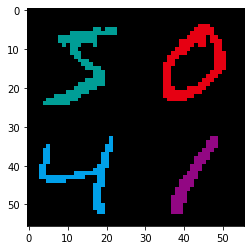

In [11]:
plt.imshow(frame_to_image(td['t_train'][0].reshape(11, 56, 56)))

# ネットワーク構築

In [12]:
data_path = 'MnistSegMobileNetDistillation'
os.makedirs(data_path, exist_ok=True)

ref_affine_list = []
ref_norm_list   = []
target_lut_list = []

def clear_list():
    ref_affine_list.clear()
    ref_norm_list.clear()
    target_lut_list.clear()

def save_model_list(model_list, name, path='.'):
    os.makedirs(os.path.join(data_path, path), exist_ok=True)
    for i, model in enumerate(model_list):
        model.save_json(os.path.join(data_path, path, '%s_%d.json' % (name, i)))

def load_model_list(model_list, name, path='.'):
    for i, model in enumerate(model_list):
        filename = os.path.join(data_path, path, '%s_%d.json' % (name, i))
        if not os.path.exists(filename):
            return False
        model.load_json(filename)
    return True

def save_all_model(path='.'):
    save_model_list(ref_affine_list, 'ref_affine',    path)
    save_model_list(ref_norm_list,   'ref_norm_list', path)
    save_model_list(target_lut_list, 'target_lut',    path)
    
def load_all_model(path='.'):
    if not load_model_list(ref_affine_list, 'ref_affine',    path): return False
    if not load_model_list(ref_norm_list,   'ref_norm_list', path): return False
    if not load_model_list(target_lut_list, 'target_lut',    path): return False
    return True

def make_common_layer(model):
    layer = {}
    layer['type']   = 'common'
    layer['select'] = 'common'
    layer['common'] = model
    return layer    

def make_cnv_layer(ch_size, w=3, h=3, connection='random', padding='same'):
    # setup infomation
    layer = {}
    layer['type']            = 'convolution'
    layer['select']          = 'ref'
    layer['connection']      = connection
    layer['target_lut_size'] = 2
    
    # create model
    if connection == 'depthwise':
        layer['ref_affine']  = bb.DepthwiseDenseAffine.create([ch_size])
        layer['target_lut0'] = bb.SparseLut6.create([1, 1, ch_size], connection='depthwise')
        layer['target_lut1'] = bb.SparseLut6.create([6, 1, ch_size], connection='depthwise')
    else:
        layer['ref_affine']  = bb.DenseAffine.create([ch_size])
        layer['target_lut0'] = bb.SparseLut6.create([1, 1, ch_size])
        layer['target_lut1'] = bb.SparseLut6.create([1, 1, ch_size*6])
    layer['ref_norm']        = bb.BatchNormalization.create()
    layer['ref_act']         = bb.ReLU.create()
    
    # save
    ref_affine_list.append(layer['ref_affine'])
    ref_norm_list.append(layer['ref_norm'])
    target_lut_list.append(layer['target_lut1'])
    target_lut_list.append(layer['target_lut0'])
    
    # make network
    ref_subnet =  bb.Sequential.create()
    ref_subnet.add(layer['ref_affine'])
    ref_subnet.add(layer['ref_norm'])
    ref_subnet.add(layer['ref_act'])
    layer['ref'] = bb.LoweringConvolution.create(ref_subnet, w, h, 1, 1, padding=padding)
    
    target_subnet = bb.Sequential.create()
    target_subnet.add(layer['target_lut1'])
    target_subnet.add(layer['target_lut0'])
    layer['target'] = bb.LoweringConvolution.create(target_subnet, w, h, 1, 1, padding=padding)
    
    return layer

def build_net(layer_list):
    net = bb.Sequential.create()
    for layer in layer_list:
        net.add(layer[layer['select']])
    return net

In [13]:
# build network
modulation_size = 1
layer_rel2bin = bb.RealToBinary.create(modulation_size, framewise=True)
layer_bin2rel = bb.BinaryToReal.create(modulation_size)

clear_list()
layer_list = []
layer_list.append(make_common_layer(layer_rel2bin))
layer_list.append(make_cnv_layer(36, 3, 3, 'random'))
for _ in range(20):
    layer_list.append(make_cnv_layer(36, 3, 3, 'depthwise'))
    layer_list.append(make_cnv_layer(36, 1, 1, 'pointwise'))
layer_list.append(make_cnv_layer(36, 3, 3, 'depthwise'))
layer_list.append(make_cnv_layer(11, 1, 1, 'pointwise'))
layer_list.append(make_common_layer(layer_bin2rel))


In [14]:
main_net = build_net(layer_list)
main_net.set_input_shape(td['x_shape'])
main_net.send_command('binary true')

In [15]:
for layer in layer_list:
    if layer['type'] != 'common':
        layer['target'].set_input_shape(layer['ref'].get_input_shape())

In [16]:
if not load_all_model('base'):
    print(main_net.get_info())

    # train
    loss      = bb.LossSoftmaxCrossEntropy.create()
    metrics   = bb.MetricsCategoricalAccuracy.create()
    optimizer = bb.OptimizerAdam.create()
    optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())
    
    runner = bb.Runner(main_net, "mnist-seg-mobile-net", loss, metrics, optimizer)
    runner.fitting(td, epoch_size=8, mini_batch_size=2, file_write=False, file_read=False)
    
    save_all_model('base')

In [17]:
def plot_image(net, td):
    x_buf = bb.FrameBuffer()
    x_buf.resize(16, td['x_shape'])
    x_buf.set_data(td['x_test'][0:16])
    y_buf = net.forward(x_buf, False)

    data = y_buf.get_data(0)

    frame = np.array(data[0]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))
    plt.show()

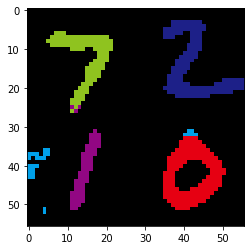

In [18]:
plot_image(main_net, td)

In [19]:
def distillation_layer(layer):
    if layer['type'] != 'convolution':
        return False
    
    ref_affine  = layer['ref_affine']
    target_lut0 = layer['target_lut0']
    target_lut1 = layer['target_lut1']
    
    if False: # layer['connection'] == 'pointwise':
        tensorW = layer['ref_affine'].W()
        W = np.array(tensorW.get_data()).reshape(tensorW.get_shape()[::-1])
        idx = np.argsort(-np.abs(W), axis=1)
        
        # Weight順で接続
        lut0_input_shape  = target_lut0.get_input_shape()
        lut0_output_shape = target_lut0.get_output_shape()
        for i in range(lut0_output_shape[2]):
            for j in range(6):
                target_lut0.set_node_connection_index(i, j, i*6+j)
        
        lut1_input_node_size  = target_lut1.get_input_node_size()
        lut1_output_node_size = target_lut1.get_output_node_size()
        for i in range(lut1_output_node_size//6):
            for j in range(6):
                for k in range(6):
                    target_lut1.set_node_connection_index(i*6+j, k, idx[i][j*6+k])
    
    layer['select'] = 'target'
    return True

In [20]:
print(distillation_layer(layer_list[1]))

main_net = build_net(layer_list)
main_net.set_input_shape(td['x_shape'])
main_net.send_command('binary true')

print(main_net.get_info())

True
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 36}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {1, 1, 216}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {1, 1, 216}       output sha

0
1
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 36}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {1, 1, 216}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {1, 1, 216}       output shap

epoch=1 test_accuracy=0.799149 test_loss=5241.737975 train_accuracy=0.791741 train_loss=5245.642176


epoch=2 test_accuracy=0.948560 test_loss=4908.127209 train_accuracy=0.949737 train_loss=4909.190945


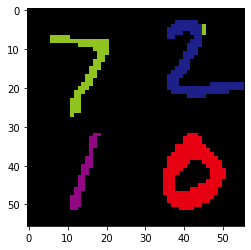

2
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 36}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {1, 1, 216}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {1, 1, 216}       output shape 

epoch=1 test_accuracy=0.436970 test_loss=6390.704118 train_accuracy=0.434585 train_loss=6388.215156


epoch=2 test_accuracy=0.951619 test_loss=4905.423193 train_accuracy=0.950893 train_loss=4906.785798


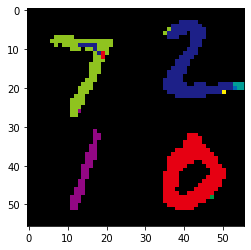

3
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 36}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {1, 1, 216}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {1, 1, 216}       output shape 

epoch=1 test_accuracy=0.890439 test_loss=5111.073390 train_accuracy=0.891261 train_loss=5107.995984


epoch=2 test_accuracy=0.937279 test_loss=4954.778635 train_accuracy=0.936631 train_loss=4956.768846


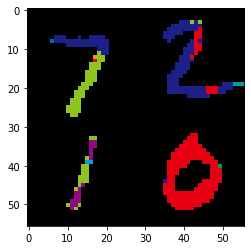

4
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 36}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {1, 1, 216}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {1, 1, 216}       output shape 

epoch=1 test_accuracy=0.954570 test_loss=4904.130867 train_accuracy=0.953477 train_loss=4905.763134


epoch=2 test_accuracy=0.954016 test_loss=4900.648266 train_accuracy=0.952829 train_loss=4902.309486


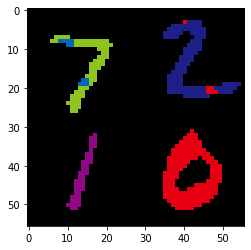

5
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 36}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {1, 1, 216}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {1, 1, 216}       output shape 

epoch=1 test_accuracy=0.953271 test_loss=4903.313041 train_accuracy=0.952324 train_loss=4905.119233


epoch=2 test_accuracy=0.961500 test_loss=4895.447731 train_accuracy=0.960333 train_loss=4896.948886


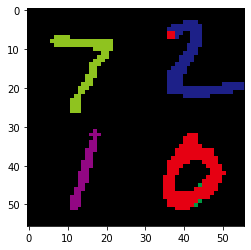

6
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 36}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {1, 1, 216}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {1, 1, 216}       output shape 

epoch=1 test_accuracy=0.941320 test_loss=4938.576275 train_accuracy=0.939903 train_loss=4941.442229


epoch=2 test_accuracy=0.943769 test_loss=4908.457305 train_accuracy=0.948320 train_loss=4909.656079


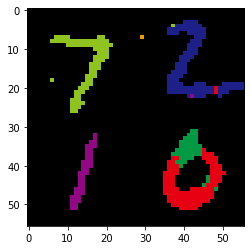

7
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 36}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {1, 1, 216}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {1, 1, 216}       output shape 

epoch=1 test_accuracy=0.947292 test_loss=4933.315756 train_accuracy=0.947076 train_loss=4934.201671


KeyboardInterrupt: 

In [22]:
# train
if True:
    for i in range(len(layer_list)):
        print(i)
        if distillation_layer(layer_list[i]):
            load_all_model('%03d' % i)
            main_net = build_net(layer_list)
            main_net.set_input_shape(td['x_shape'])
            main_net.send_command('binary true')

            print(main_net.get_info())

            loss      = bb.LossSoftmaxCrossEntropy.create()
            metrics   = bb.MetricsCategoricalAccuracy.create()
            optimizer = bb.OptimizerAdam.create()
            optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())

            runner = bb.Runner(main_net, "mnist-seg-mobile-net", loss, metrics, optimizer)
            runner.fitting(td, epoch_size=2, mini_batch_size=16, file_write=False, file_read=False)

            save_all_model('%03d' % i)
                
            plot_image(main_net, td)

In [ ]:
save_model_list(target_lut_list, 'target_lut')

In [ ]:
save_all_model()

In [ ]:
print(len(ref_affine_list))